In [1]:
! pip install arabert
# Install required packages first
!pip install datasets transformers tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.4 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=5e0aa638481b0162e938e9b044150b70e235631266d7415a26c1c9e2079280ac
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

Imports : 

In [2]:

import pandas as pd 
from datasets import Dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from arabert.preprocess import ArabertPreprocessor
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

import seaborn as sns

2025-06-12 11:04:25.681193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749726265.876147      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749726265.933057      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load data
df = pd.read_csv("/kaggle/input/arabic-company-reviews/CompanyReviews.csv")
print("Original data:")
print(df.head())
print("*"*100)
df.info()
print("*"*100)

Original data:
   Unnamed: 0                                 review_description  rating  \
0           0                                               رائع       1   
1           1  برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...       1   
2           2  التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...      -1   
3           3                 لماذا لا يمكننا طلب من ماكدونالدز؟      -1   
4           4  البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...      -1   

  company  
0  talbat  
1  talbat  
2  talbat  
3  talbat  
4  talbat  
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40046 entries, 0 to 40045
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          40046 non-null  int64 
 1   review_description  40045 non-null  object
 2   rating              40046 non-null  int64 
 3   co

In [4]:
# Initialize AraBERT preprocessor
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

# Preprocess Arabic text
print("Preprocessing Arabic text...")
df["review_description"] = df["review_description"].apply(arabert_prep.preprocess)

# Drop unnecessary columns
df.drop(['company','Unnamed: 0'], axis=1, inplace=True)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [11:46<00:00, 341kiB/s]


[2025-06-12 11:16:25,772 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Preprocessing Arabic text...


In [5]:
# Handle missing values
df = df.dropna(subset=['review_description'])
print(f"Data shape after dropping NaN: {df.shape}")

# Fix label encoding - convert ratings to 0-indexed classes
print("Original rating distribution:")
print(df['rating'].value_counts())

# Convert ratings to proper class indices (0, 1, 2, ...)
label_encoder = LabelEncoder()
df['rating'] = label_encoder.fit_transform(df['rating'])
print("Encoded rating distribution:")
print(df['rating'].value_counts())
print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")


Data shape after dropping NaN: (40046, 2)
Original rating distribution:
rating
 1    23921
-1    14200
 0     1925
Name: count, dtype: int64
Encoded rating distribution:
rating
2    23921
0    14200
1     1925
Name: count, dtype: int64
Label mapping:
  -1 -> 0
  0 -> 1
  1 -> 2


In [6]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


Training set size: 32036
Test set size: 8010


In [7]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(example):
    return tokenizer(
        example["review_description"], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )

# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
print("Token size = {}".format(len(tokenized_train.to_pandas()['input_ids'][0])))

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/32036 [00:00<?, ? examples/s]

Map:   0%|          | 0/8010 [00:00<?, ? examples/s]

Token size = 512


In [8]:
# Convert to TensorFlow datasets
def convert_to_tf_dataset(dataset, batch_size=32):
    # Remove text columns but keep __index_level_0__ if it exists
    columns_to_remove = ["review_description"]
    if "__index_level_0__" in dataset.column_names:
        columns_to_remove.append("__index_level_0__")
    
    dataset = dataset.remove_columns(columns_to_remove)
    
    # Create features dictionary
    features = {x: dataset[x] for x in tokenizer.model_input_names}
    
    # Create TensorFlow dataset
    tf_dataset = tf.data.Dataset.from_tensor_slices((features, dataset["rating"]))
    return tf_dataset.shuffle(1000).batch(batch_size)

print("Converting to TensorFlow datasets...")
train_tf_dataset = convert_to_tf_dataset(tokenized_train, batch_size=8)
test_tf_dataset = convert_to_tf_dataset(tokenized_test, batch_size=8)
print("done")

Converting to TensorFlow datasets...


I0000 00:00:1749727070.342110      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


done


In [9]:
# Model setup
num_labels = len(label_encoder.classes_)
print(f"Number of labels: {num_labels}")

# Initialize model
print("Loading pre-trained model...")
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels
)





initial_learning_rate = 2e-5  
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate,
    decay_steps=len(train_tf_dataset) * 5,  # Total training steps
    end_learning_rate=1e-6,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_lr=1e-7
    )
]

print("Model compiled successfully!")
print("Starting training...")


Number of labels: 3
Loading pre-trained model...


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model compiled successfully!
Starting training...


In [10]:
# Train the model
history = model.fit(
    train_tf_dataset, 
    validation_data=test_tf_dataset, 
    epochs=5,  # Increased epochs with early stopping
    callbacks=callbacks,
    verbose=1
)

# Save the model
print("Saving model...")
model.save_pretrained('/kaggle/working//arabic_sentiment_model')

print("Training completed!")


Epoch 1/5


I0000 00:00:1749727177.366060     130 service.cc:148] XLA service 0x78689158a980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749727177.366875     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749727177.439822     130 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749727177.574452     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4005/4005 [==============================] - 2533s 619ms/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8410 - val_loss: 0.4120 - val_sparse_categorical_accuracy: 0.8577 - lr: 1.6201e-05
Epoch 2/5
4005/4005 [==============================] - 2475s 618ms/step - loss: 0.3679 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.4066 - val_sparse_categorical_accuracy: 0.8602 - lr: 1.2401e-05
Epoch 3/5
4005/4005 [==============================] - 2476s 618ms/step - loss: 0.3072 - sparse_categorical_accuracy: 0.8911 - val_loss: 0.4226 - val_sparse_categorical_accuracy: 0.8519 - lr: 8.6009e-06
Epoch 4/5
4005/4005 [==============================] - 2475s 618ms/step - loss: 0.2459 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.4547 - val_sparse_categorical_accuracy: 0.8481 - lr: 4.8009e-06
Saving model...
Training completed!


In [11]:
# Print final results
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['sparse_categorical_accuracy'][-1]
final_val_acc = history.history['val_sparse_categorical_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Loss: 0.2459
Final Validation Loss: 0.4547
Final Training Accuracy: 0.9162
Final Validation Accuracy: 0.8481


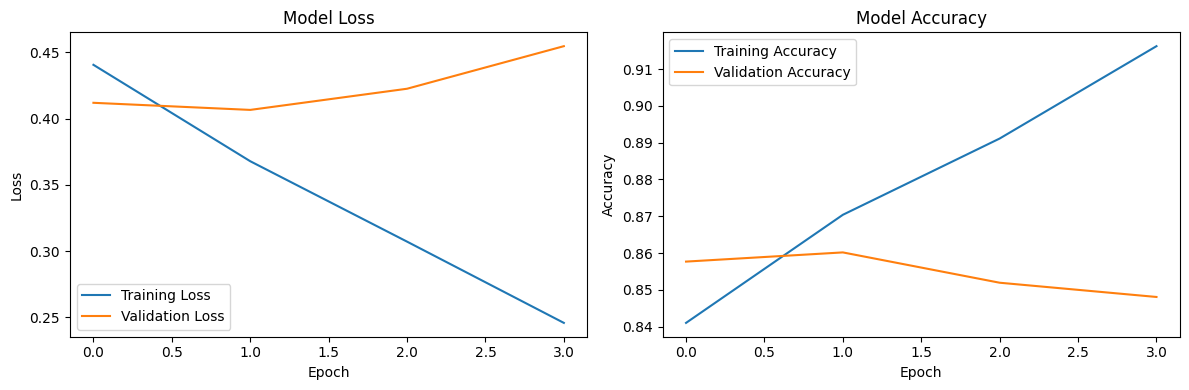

Script completed successfully!


In [12]:
# Optional: Plot training history
try:
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib not available for plotting. Install with: pip install matplotlib")

print("Script completed successfully!")

In [13]:
with open('/kaggle/working/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
def classify_text(text):
    """
    Classify Arabic text and return prediction with confidence
    
    Args:
        text (str): Arabic text to classify
        
    Returns:
        dict: Contains predicted class, confidence, and all probabilities
    """
    
    # Preprocess the text
    processed_text = arabert_prep.preprocess(text)
    
    # Tokenize
    encoding = tokenizer(
        processed_text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors='tf'
    )
    
    # Make prediction
    predictions = model(encoding)
    probabilities = tf.nn.softmax(predictions.logits, axis=-1).numpy()[0]
    
    # Get predicted class
    predicted_class_idx = np.argmax(probabilities)
    predicted_class = label_encoder.classes_[predicted_class_idx]
    confidence = probabilities[predicted_class_idx]
    
    # Create probability dictionary for all classes
    class_probabilities = {}
    for i, class_name in enumerate(label_encoder.classes_):
        class_probabilities[str(class_name)] = float(probabilities[i])
    
    return {
        'text': text,
        'processed_text': processed_text,
        'predicted_class': str(predicted_class),
        'confidence': float(confidence),
        'all_probabilities': class_probabilities
    }